In [1]:
# imports
import time

# data handling
import pandas as pd
import numpy as np

# database connection
from sqlalchemy import create_engine
from config import db_key

# models and measures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb

# visualization
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

# Data Loading

In [2]:
# load datasets with sqlalchemy and pandas
# create database connection using SQLAlchemy
user = "Housing_Database"
password = db_key
host = "housing-database.c6zoxppofyzr.us-east-1.rds.amazonaws.com"
port = '5432'
database = "postgres"
# connection string
con_string = f'postgresql://{user}:{password}@{host}:{port}/{database}'
# engine
engine = create_engine(con_string)

# original dataset 
original_features_df = pd.read_sql('SELECT * FROM original_features', engine)

print('-----original_features_df-----')
print(f'Shape: {original_features_df.shape}')
print(original_features_df.dtypes)

# joined dataset
# query to join tables
j_query = 'SELECT o.*, c.bedrooms_per_rooms, c.rooms_per_house, c.pop_per_house, c.miles_nearest_major_city \
    FROM original_features as o\
    INNER JOIN created_features as c ON o.id = c.id;'
joined_features_df = pd.read_sql_query(j_query, engine)

print('\n-----joined_features_df-----')
print(f'Shape: {joined_features_df.shape}')
print(joined_features_df.dtypes)

-----original_features_df-----
Shape: (20640, 9)
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
id                      int64
dtype: object

-----joined_features_df-----
Shape: (20640, 13)
housing_median_age          float64
total_rooms                 float64
total_bedrooms              float64
population                  float64
households                  float64
median_income               float64
median_house_value          float64
ocean_proximity              object
id                            int64
bedrooms_per_rooms          float64
rooms_per_house             float64
pop_per_house               float64
miles_nearest_major_city    float64
dtype: object


# Categorical Feature Encoding

In [3]:
# encode categorical feature ocean_proximity of original data with OneHotEncoder 

# select data to be encoded
ocean_prox = original_features_df[['ocean_proximity']].values.reshape(-1,1)
# create encoder, set sparse to false
encoder = OneHotEncoder(sparse=False)
# fit and transform training data
original_encoder_df = pd.DataFrame(encoder.fit_transform(ocean_prox))
# replace column names
original_encoder_df.columns = encoder.get_feature_names_out(['ocean_proximity'])


original_encoder_df.head()

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0


In [4]:
# encode categorical feature ocean_proximity of joined data with OneHotEncoder 

# select data to be encoded
ocean_prox = joined_features_df[['ocean_proximity']].values.reshape(-1,1)
# create encoder, set sparse to false
encoder = OneHotEncoder(sparse=False)
# fit and transform training data
joined_encoder_df = pd.DataFrame(encoder.fit_transform(ocean_prox))
# replace column names
joined_encoder_df.columns = encoder.get_feature_names_out(['ocean_proximity'])


joined_encoder_df.tail()

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
20635,0.0,1.0,0.0,0.0,0.0
20636,0.0,1.0,0.0,0.0,0.0
20637,0.0,1.0,0.0,0.0,0.0
20638,0.0,1.0,0.0,0.0,0.0
20639,0.0,1.0,0.0,0.0,0.0


# Numerical Feature Scaling

In [5]:
# scale numerical features of original dataset with StandardScaler

# select numerical features, drop dependent variable
original_num_df = original_features_df.select_dtypes(include='float').drop(columns='median_house_value', axis=1)

# create scaler
scaler = StandardScaler()

# fit and scale numerical features
original_scaled_df = pd.DataFrame(scaler.fit_transform(original_num_df))
original_scaled_df.columns = original_num_df.columns
original_scaled_df.head()


,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,0.982143,-0.804819,-0.972476,-0.974429,-0.977033,2.344766
1,-0.607019,2.045890,1.357143,0.861439,1.669961,2.332238
2,1.856182,-0.535746,-0.827024,-0.820777,-0.843637,1.782699
3,1.856182,-0.624215,-0.719723,-0.766028,-0.733781,0.932968
4,1.856182,-0.462404,-0.612423,-0.759847,-0.629157,-0.012881


In [6]:
# scale numerical features of joined dataset with StandardScaler

# select numerical features, drop dependent variable
joined_num_df = joined_features_df.select_dtypes(include='float').drop(columns='median_house_value', axis=1)

# create scaler
scaler = StandardScaler()

# fit and scale numerical features
joined_scaled_df = pd.DataFrame(scaler.fit_transform(joined_num_df))
joined_scaled_df.columns = joined_num_df.columns
joined_scaled_df.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,bedrooms_per_rooms,rooms_per_house,pop_per_house,miles_nearest_major_city
0,0.982143,-0.804819,-0.972476,-0.974429,-0.977033,2.344766,-1.029988,0.628559,-0.049597,-0.644914
1,-0.607019,2.045890,1.357143,0.861439,1.669961,2.332238,-0.888897,0.327041,-0.092512,-0.650205
2,1.856182,-0.535746,-0.827024,-0.820777,-0.843637,1.782699,-1.291686,1.155620,-0.025843,-0.677508
3,1.856182,-0.624215,-0.719723,-0.766028,-0.733781,0.932968,-0.449613,0.156966,-0.050329,-0.687668
4,1.856182,-0.462404,-0.612423,-0.759847,-0.629157,-0.012881,-0.639087,0.344711,-0.085616,-0.687668


# Combine prepared data

In [7]:
# combine encoded and scaled features to create final original dataset

proc_original_features = original_scaled_df.merge(original_encoder_df,left_index=True, right_index=True)
proc_original_features.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.982143,-0.804819,-0.972476,-0.974429,-0.977033,2.344766,0.0,0.0,0.0,1.0,0.0
1,-0.607019,2.045890,1.357143,0.861439,1.669961,2.332238,0.0,0.0,0.0,1.0,0.0
2,1.856182,-0.535746,-0.827024,-0.820777,-0.843637,1.782699,0.0,0.0,0.0,1.0,0.0
3,1.856182,-0.624215,-0.719723,-0.766028,-0.733781,0.932968,0.0,0.0,0.0,1.0,0.0
4,1.856182,-0.462404,-0.612423,-0.759847,-0.629157,-0.012881,0.0,0.0,0.0,1.0,0.0


In [8]:
# combine encoded and scaled features to create final joined dataset
proc_joined_features = joined_scaled_df.merge(joined_encoder_df,left_index=True, right_index=True)
proc_joined_features.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,bedrooms_per_rooms,rooms_per_house,pop_per_house,miles_nearest_major_city,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.982143,-0.804819,-0.972476,-0.974429,-0.977033,2.344766,-1.029988,0.628559,-0.049597,-0.644914,0.0,0.0,0.0,1.0,0.0
1,-0.607019,2.045890,1.357143,0.861439,1.669961,2.332238,-0.888897,0.327041,-0.092512,-0.650205,0.0,0.0,0.0,1.0,0.0
2,1.856182,-0.535746,-0.827024,-0.820777,-0.843637,1.782699,-1.291686,1.155620,-0.025843,-0.677508,0.0,0.0,0.0,1.0,0.0
3,1.856182,-0.624215,-0.719723,-0.766028,-0.733781,0.932968,-0.449613,0.156966,-0.050329,-0.687668,0.0,0.0,0.0,1.0,0.0
4,1.856182,-0.462404,-0.612423,-0.759847,-0.629157,-0.012881,-0.639087,0.344711,-0.085616,-0.687668,0.0,0.0,0.0,1.0,0.0


# Split Datasets

In [9]:
# seperate target and features
# original data
y_original = original_features_df['median_house_value'].copy()
X_original = proc_original_features

# joined data
y_joined = joined_features_df['median_house_value'].copy()
X_joined = proc_joined_features
 

# split datasets with train test split
# original data
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X_original, y_original, 
                                                                                test_size=0.20, random_state=5)

# joined data
X_train_joined, X_test_joined, y_train_joined, y_test_joined = train_test_split(X_joined, y_joined, 
                                                                        test_size=0.20, random_state=5)

print(f'Original Feature Training Shape: {X_train_original.shape}')
print(f'Joined Feature Training Shape: {X_train_joined.shape}')
# 11 features in original data, 15 features in joined data

Original Feature Training Shape: (16512, 11)
Joined Feature Training Shape: (16512, 15)


In [10]:
# data collection
# here we create a list to hold a dictionary of metrics for each model
metrics = []

In [11]:
# metrics.pop()
# len(metrics)

# Original Dataset and RandomForestRegressor

## RandomForestRegressor Base Model and Original Data

In [12]:
# create model
rf = RandomForestRegressor(random_state=5)
# fit model to training data
rf.fit(X_train_original, y_train_original)
# make predictions
y_pred_original = rf.predict(X_test_original)

# get r^2 for training and testing sets
r1 = rf.score(X_train_original, y_train_original)
r2 = rf.score(X_test_original, y_test_original)
# get variance score
evs = explained_variance_score(y_test_original, y_pred_original)
# get rmse
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))

# save metrics
metrics.append({'Model': 'RFO_B', 'R2': r2, 'EVS': evs, 'RMSE': rmse})
# print results
print(f'RMSE of Random Forest on Original training set: {round(rmse, 3)}')
print(f'R^2 of Random Forest on Original training set: {round(r1, 3)}')
print(f'R^2 of Random Forest on Original testing set: {round(r2, 3)}')
print(f'Explained Variance Score of Random Forest on Original testing set: {round(evs, 3)}')

RMSE of Random Forest on Original training set: 61574.091
R^2 of Random Forest on Original training set: 0.959
R^2 of Random Forest on Original testing set: 0.725
Explained Variance Score of Random Forest on Original testing set: 0.725


## Conduct RandomizeSearchCV parameter tuning

In [13]:
# hyperparameter tuning randomforest on original dataset with Randomized Search Cross Validation
start=time.time()
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=5, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_original, y_train_original)
end=time.time()
print(f'Training Time: {end-start}s')
# print best params
best_pr = rf_random.best_params_
print(best_pr)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training Time: 1260.5103795528412s
{'n_estimators': 700, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}


In [61]:
print(best_pr)

{'n_estimators': 700, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}


## Train Model with Best params get metrics and predictions

In [14]:
# test RandomForestRegressor with original dataset and best parameters from tuning.

# create model with best params from RandomSearchCV
rf = RandomForestRegressor(n_estimators=best_pr['n_estimators'], min_samples_split=best_pr['min_samples_split'], 
                            min_samples_leaf=best_pr['min_samples_leaf'], max_depth=best_pr['max_depth'], 
                            max_features = best_pr['max_features'], bootstrap=best_pr['bootstrap'], random_state=5)
# fit model to training data
rf.fit(X_train_original, y_train_original)
# make predictions
y_pred_original = rf.predict(X_test_original)

# get r^2 for training and testing sets
r1 = rf.score(X_train_original, y_train_original)
r2 = rf.score(X_test_original, y_test_original)
# get variance score
evs = explained_variance_score(y_test_original, y_pred_original)
# get rmse
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))

# save metrics
metrics.append({'Model': 'RFO_T', 'R2': r2, 'EVS': evs, 'RMSE': rmse})
# print results
print(f'RMSE of Random Forest on Original training set: {round(rmse, 3)}')
print(f'R^2 of Random Forest on Original training set: {round(r1, 3)}')
print(f'R^2 of Random Forest on Original testing set: {round(r2, 3)}')
print(f'Explained Variance Score of Random Forest on Original testing set: {round(evs, 3)}')


RMSE of Random Forest on Original training set: 60369.882
R^2 of Random Forest on Original training set: 0.93
R^2 of Random Forest on Original testing set: 0.736
Explained Variance Score of Random Forest on Original testing set: 0.736


## Plot True vs. Predicted Values

Text(0.5, 1.0, 'True vs. Pred Value Density, RF Original')

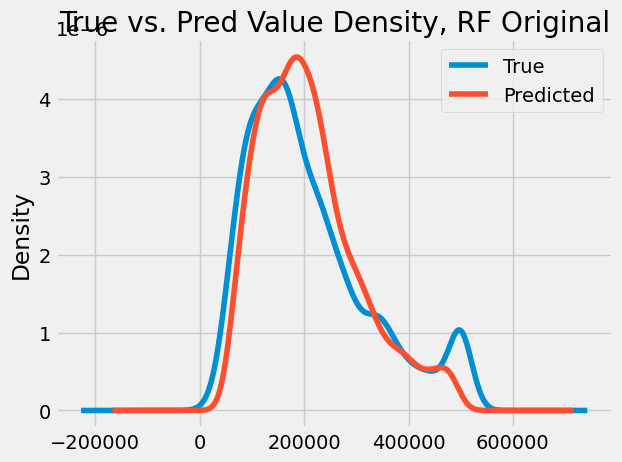

In [15]:
# plot distributions of true and predicted values
y_test_original.plot.density(label='True')
pd.Series(y_pred_original).plot.density(label='Predicted')
plt.legend()
plt.title('True vs. Pred Value Density, RF Original')

Text(0.5, 1.0, 'True vs. Predicted Values, RF with Original Features')

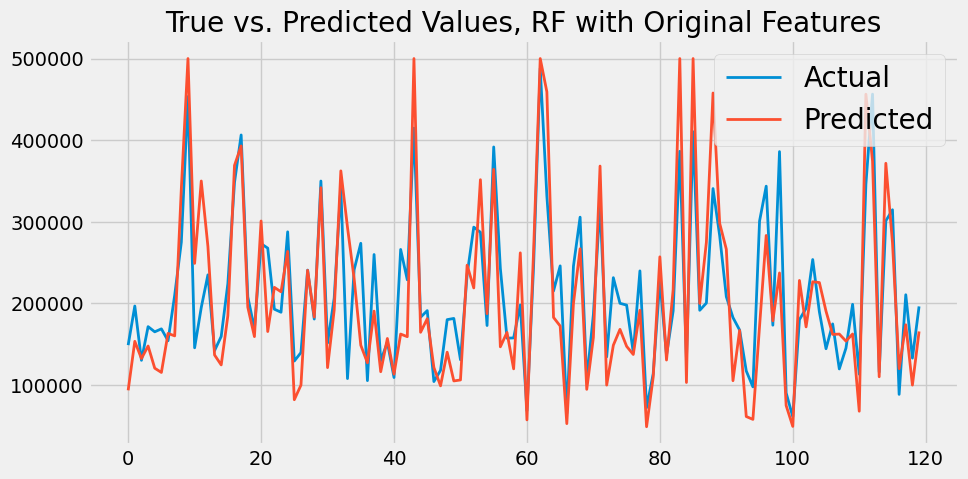

In [16]:
# show predictions
rfj = pd.DataFrame({'prediction':y_pred_original,'Actual':y_test_original})
rfj = rfj.reset_index()
rfj = rfj.drop(['index'],axis=1)
plt.figure(figsize=(10,5))
plt.plot(rfj[:120],linewidth=2)
plt.legend(['Actual','Predicted'],prop={'size': 20})
plt.title('True vs. Predicted Values, RF with Original Features')

## Plot Feature Importances

Text(0.5, 1.0, 'Feature Importances, RF Original')

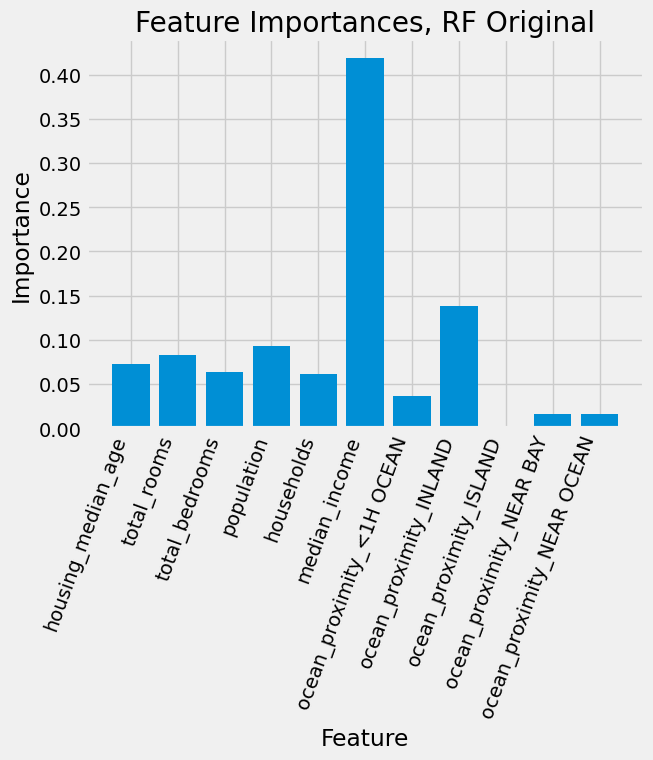

In [17]:
# plot feature importances of model
# Set the style
importances = rf.feature_importances_
feature_list = X_test_original.columns

# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation=70, ha='right')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Feature'); plt.title('Feature Importances, RF Original')

# Joined Dataset and Random Forest Regressor

## RandomForestRegressor Base Model and Joined Data

In [18]:
# create model
rf = RandomForestRegressor(random_state=5)
# fit model to training data
rf.fit(X_train_joined, y_train_joined)
# make predictions
y_pred_joined = rf.predict(X_test_joined)

# get r^2 for training and testing sets
r1 = rf.score(X_train_joined, y_train_joined)
r2 = rf.score(X_test_joined, y_test_joined)
# get variance score
evs = explained_variance_score(y_test_joined, y_pred_joined)
# get rmse
rmse = np.sqrt(mean_squared_error(y_test_joined, y_pred_joined))

# save metrics
metrics.append({'Model': 'RFJ_B', 'R2': r2, 'EVS': evs, 'RMSE': rmse})
# print results
print(f'RMSE of Random Forest on joined training set: {round(rmse, 3)}')
print(f'R^2 of Random Forest on joined training set: {round(r1, 3)}')
print(f'R^2 of Random Forest on joined testing set: {round(r2, 3)}')
print(f'Explained Variance Score of Random Forest on joined testing set: {round(evs, 3)}')

RMSE of Random Forest on joined training set: 54200.234
R^2 of Random Forest on joined training set: 0.969
R^2 of Random Forest on joined testing set: 0.787
Explained Variance Score of Random Forest on joined testing set: 0.787


## Parameter tuning on the joined dataset

In [19]:
# hyperparameter tuning randomforest on original dataset with Randomized Search Cross Validation
start=time.time()
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=5, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_joined, y_train_joined)

end=time.time()
print(f'Training Time: {end-start}s')
# print best params
best_pr_joined = rf_random.best_params_
print(best_pr_joined)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training Time: 2027.7717683315277s
{'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}


## Train Model with best params and get metrics and predictions

In [20]:
# create model with best parameters from RandomSearch
rf = RandomForestRegressor(n_estimators=best_pr_joined['n_estimators'], min_samples_split=best_pr_joined['min_samples_split'], 
                            min_samples_leaf=best_pr_joined['min_samples_leaf'], max_depth=best_pr_joined['max_depth'], 
                            max_features = best_pr_joined['max_features'], bootstrap=best_pr_joined['bootstrap'], random_state=5)
# fit model to training data
rf.fit(X_train_joined, y_train_joined)
# make predictions
y_pred_joined = rf.predict(X_test_joined)

# get r^2 for training and testing sets
r1 = rf.score(X_train_joined, y_train_joined)
r2 = rf.score(X_test_joined, y_test_joined)
# get variance score
evs = explained_variance_score(y_test_joined, y_pred_joined)
# get rmse
rmse = np.sqrt(mean_squared_error(y_test_joined, y_pred_joined))

# save metrics
metrics.append({'Model': 'RFJ_T', 'R2': r2, 'EVS': evs, 'RMSE': rmse})
# print results
print(f'RMSE of Random Forest on joined training set: {round(rmse, 3)}')
print(f'R^2 of Random Forest on joined training set: {round(r1, 3)}')
print(f'R^2 of Random Forest on joined testing set: {round(r2, 3)}')
print(f'Explained Variance Score of Random Forest on joined testing set: {round(evs, 3)}')

RMSE of Random Forest on joined training set: 53364.909
R^2 of Random Forest on joined training set: 0.993
R^2 of Random Forest on joined testing set: 0.793
Explained Variance Score of Random Forest on joined testing set: 0.793


## Plot True vs. Predicted values of RandomForestRegressor with joined dataset

Text(0.5, 1.0, 'True vs. Pred Value Density, RF Joined')

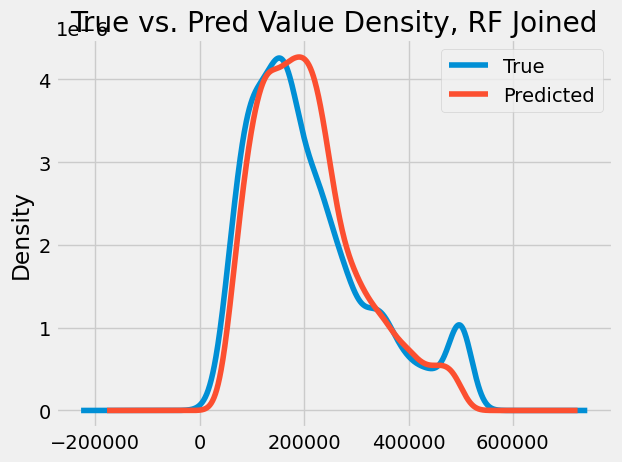

In [21]:
# plot distributions of true and predicted values
y_test_joined.plot.density(label='True')
pd.Series(y_pred_joined).plot.density(label='Predicted')
plt.legend()
plt.title('True vs. Pred Value Density, RF Joined')


Text(0.5, 1.0, 'True vs. Predicted Values, RF with Created Features')

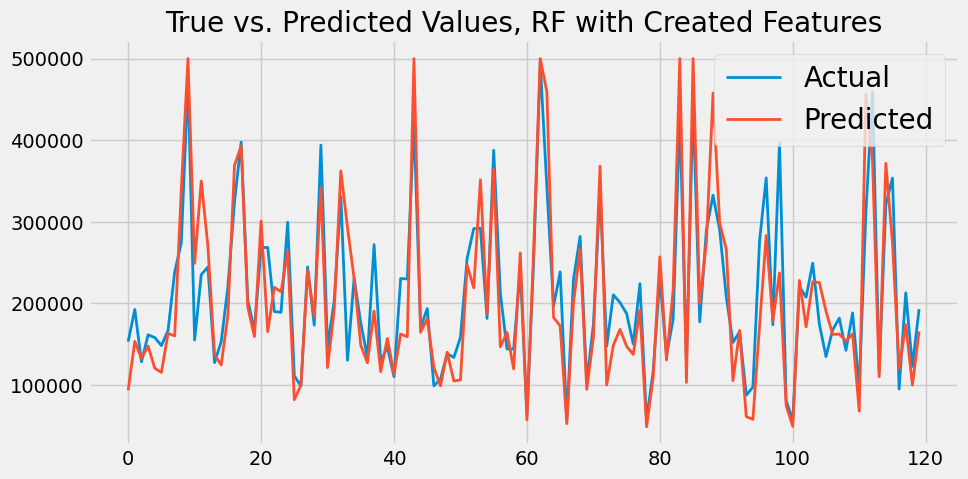

In [22]:
# show predictions
rfj = pd.DataFrame({'prediction':y_pred_joined,'Actual':y_test_joined})
rfj = rfj.reset_index()
rfj = rfj.drop(['index'],axis=1)
plt.figure(figsize=(10,5))
plt.plot(rfj[:120],linewidth=2)
plt.legend(['Actual','Predicted'],prop={'size': 20})
plt.title('True vs. Predicted Values, RF with Created Features')

## Get feature importances

Text(0.5, 1.0, 'Feature Importances, RF Joined')

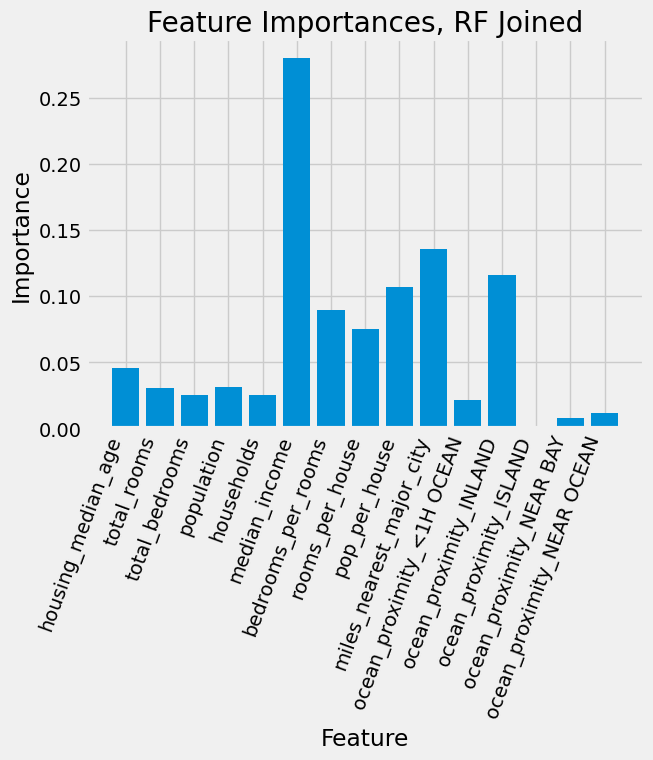

In [23]:
# plot feature importances of model
# Set the style
importances = rf.feature_importances_
feature_list = X_test_joined.columns

# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation=70, ha='right')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Feature'); plt.title('Feature Importances, RF Joined')


# Original Dataset and XGBoostRegressor

In [24]:
# feature names with [] or <> are rejected by XGboost, this changes a column title that throws the error
X_train_original.rename(columns={'ocean_proximity_<1H OCEAN':'ocean_proximity_1H OCEAN'}, inplace=True)
X_test_original.rename(columns={'ocean_proximity_<1H OCEAN':'ocean_proximity_1H OCEAN'}, inplace=True)
X_train_original.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
5500,0.505394,-0.428483,-0.130761,0.002228,-0.014490,-0.076678,1.0,0.0,0.0,0.0,0.0
15860,1.856182,-0.146575,-0.164144,-0.334215,-0.061571,0.334265,0.0,0.0,0.0,1.0,0.0
7232,0.584852,-0.757147,-0.624345,-0.354525,-0.563767,-0.918883,1.0,0.0,0.0,0.0,0.0
6115,0.346478,-0.388604,-0.192757,0.319244,-0.362365,-0.635744,1.0,0.0,0.0,0.0,0.0
8828,0.584852,-0.571042,-0.187988,-0.486983,-0.082495,-0.678749,1.0,0.0,0.0,0.0,0.0


# XGBoostRegressor Base Model and Original Data

In [25]:
# create model
xg=xgb.XGBRegressor(random_state=5)
# fit model to original data
xg.fit(X_train_original, y_train_original)
# get predictions
y_pred_xg_original = xg.predict(X_test_original)

# get r^2 for training and testing sets
x1 = xg.score(X_train_original, y_train_original)
x2 = xg.score(X_test_original, y_test_original)
# get variance score
evs = explained_variance_score(y_test_original, y_pred_xg_original)
# get rmse
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_xg_original))

# save metrics
metrics.append({'Model': 'XGO_B', 'R2': x2, 'EVS': evs, 'RMSE': rmse})
# print results
print(f'RMSE of XGboost on original training set: {round(rmse, 3)}')
print(f'R^2 of XGboost on original training set: {round(x1, 3)}')
print(f'R^2 of XGboost on original testing set: {round(x2, 3)}')
print(f'Explained Variance Score of XGboost on original testing set: {round(evs, 3)}')

RMSE of XGboost on original training set: 60885.648
R^2 of XGboost on original training set: 0.869
R^2 of XGboost on original testing set: 0.731
Explained Variance Score of XGboost on original testing set: 0.731


# Parameter tuning XGBoost with Original Dataset

In [26]:
# hyperparameter tuning with RandomSearchCV and XGboostregressor on original data
start=time.time()
# Number of trees in random forest
n_estimators=[int(i) for i in np.linspace(start = 100, stop = 700, num = 25)]
# defines the minimum sum of weights of all observations required in a child.
min_child_weight=[i for i in range(2,7)]
# Gamma specifies the minimum loss reduction required to make a split
gamma=[i/10.0 for i in range(0,7)]
# denotes the fraction of observations to be randomly samples for each tree.
subsample=[i/10.0 for i in range(4,11)]
# colsample_bytree is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
colsample=[i/10.0 for i in range(4,11)]
# The maximum depth of a tree
max_depth=[i for i in range(2,12)]
# defines the loss function to be minimize
objective=['reg:squarederror', 'reg:tweedie']
# 2 types of boosters - tree booster and linear booster
booster=['gbtree', 'gblinear']
# The metric to be used for validation data.
eval_metric=['rmse']
# It is analogous to learning rate, It is the step size shrinkage used in update to prevent overfitting
eta=[round(i, 2) for i in np.arange(0.01, 2.0, 0.01)]

random_grid_xg = {
    'n_estimators':n_estimators,
    'min_child_weight':min_child_weight, 
    'gamma':gamma,  
    'subsample':subsample,
    'colsample_bytree':colsample, 
    'max_depth':max_depth,
    'objective':objective,
    'booster':booster,
    'eval_metric':eval_metric,
    'eta':eta}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
xg = xgb.XGBRegressor(nthread=-1)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xg_random = RandomizedSearchCV(estimator = xg, param_distributions = random_grid_xg, n_iter = 200, cv = 3, verbose=2, random_state=5, n_jobs = -1, error_score='raise')
# Fit the random search model
xg_random.fit(X_train_original, y_train_original)
end=time.time()
print(f'Training Time: {end-start}')
# print best params
best_pr_original_xg = xg_random.best_params_
print(best_pr_original_xg)


Fitting 3 folds for each of 200 candidates, totalling 600 fits
Training Time: 359.13633489608765
{'subsample': 0.5, 'objective': 'reg:tweedie', 'n_estimators': 650, 'min_child_weight': 2, 'max_depth': 7, 'gamma': 0.4, 'eval_metric': 'rmse', 'eta': 0.02, 'colsample_bytree': 0.9, 'booster': 'gbtree'}


## Train Model with Best Params and get metrics and predictions

In [27]:
# create model with best params from RandomSearch
xg = xgb.XGBRegressor(n_estimators=best_pr_original_xg['n_estimators'],
                        min_child_weight=best_pr_original_xg['min_child_weight'],
                        gamma=best_pr_original_xg['gamma'],
                        subsample=best_pr_original_xg['subsample'],
                        colsample_bytree=best_pr_original_xg['colsample_bytree'],
                        max_depth=best_pr_original_xg['max_depth'],
                        objective=best_pr_original_xg['objective'],
                        booster=best_pr_original_xg['booster'],
                        eval_metric=best_pr_original_xg['eval_metric'],
                        eta=best_pr_original_xg['eta'],random_state=5)
# fit model to original data
xg.fit(X_train_original, y_train_original)
# get predictions
y_pred_xg_original = xg.predict(X_test_original)

# get r^2 for training and testing sets
x1 = xg.score(X_train_original, y_train_original)
x2 = xg.score(X_test_original, y_test_original)
# get variance score
evs = explained_variance_score(y_test_original, y_pred_xg_original)
# get rmse
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_xg_original))

# save metrics
metrics.append({'Model': 'XGO_T', 'R2': x2, 'EVS': evs, 'RMSE': rmse})
# print results
print(f'RMSE of XGboost on original training set: {round(rmse, 3)}')
print(f'R^2 of XGboost on original training set: {round(x1, 3)}')
print(f'R^2 of XGboost on original testing set: {round(x2, 3)}')
print(f'Explained Variance Score of XGboost on original testing set: {round(evs, 3)}')

RMSE of XGboost on original training set: 59353.577
R^2 of XGboost on original training set: 0.824
R^2 of XGboost on original testing set: 0.744
Explained Variance Score of XGboost on original testing set: 0.745


## Plot True vs. Predicted Values

Text(0.5, 1.0, 'True vs. Pred Value Density, XGB Original')

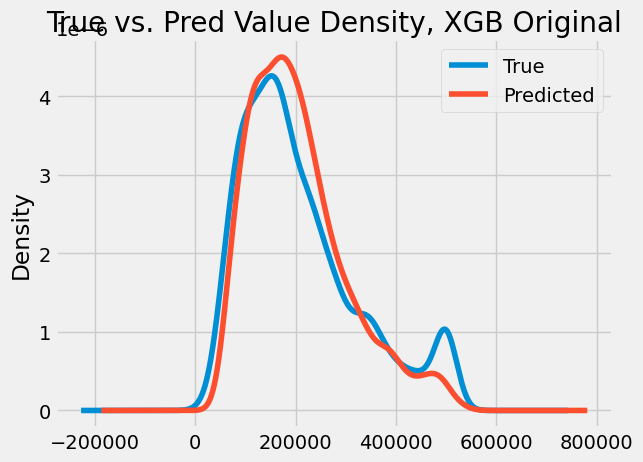

In [28]:
# plot distributions of true and predicted values
y_test_original.plot.density(label='True')
pd.Series(y_pred_xg_original).plot.density(label='Predicted')
plt.legend()
plt.title('True vs. Pred Value Density, XGB Original')

Text(0.5, 1.0, 'True vs. Predicted Values, XGB Original')

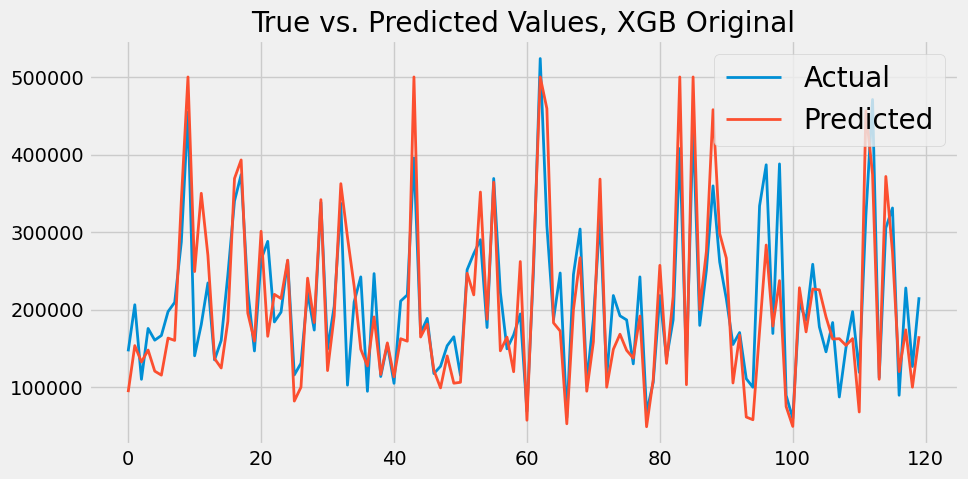

In [29]:
# show predictions
xgo = pd.DataFrame({'prediction':y_pred_xg_original,'Actual':y_test_original})
xgo = xgo.reset_index()
xgo = xgo.drop(['index'],axis=1)
plt.figure(figsize=(10,5))
plt.plot(xgo[:120],linewidth=2)
plt.legend(['Actual','Predicted'],prop={'size': 20})
plt.title('True vs. Predicted Values, XGB Original')

## Get Feature Importances

Text(0.5, 1.0, 'Feature Importances, XGB Original')

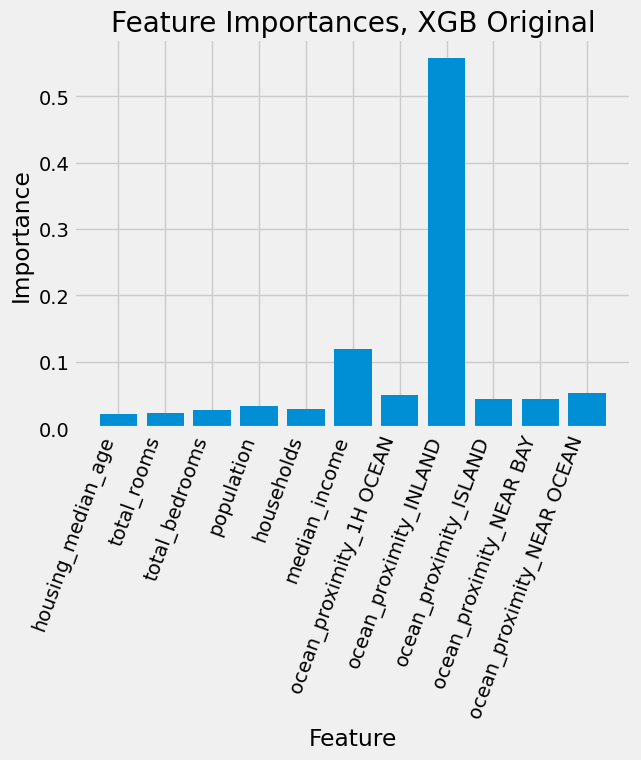

In [30]:
# plot feature importances of model
# Set the style
importances = xg.feature_importances_
feature_list = X_test_original.columns

# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation=70, ha='right')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Feature'); plt.title('Feature Importances, XGB Original')

Text(0.5, 1.0, 'Feature Importance, XGB Original')

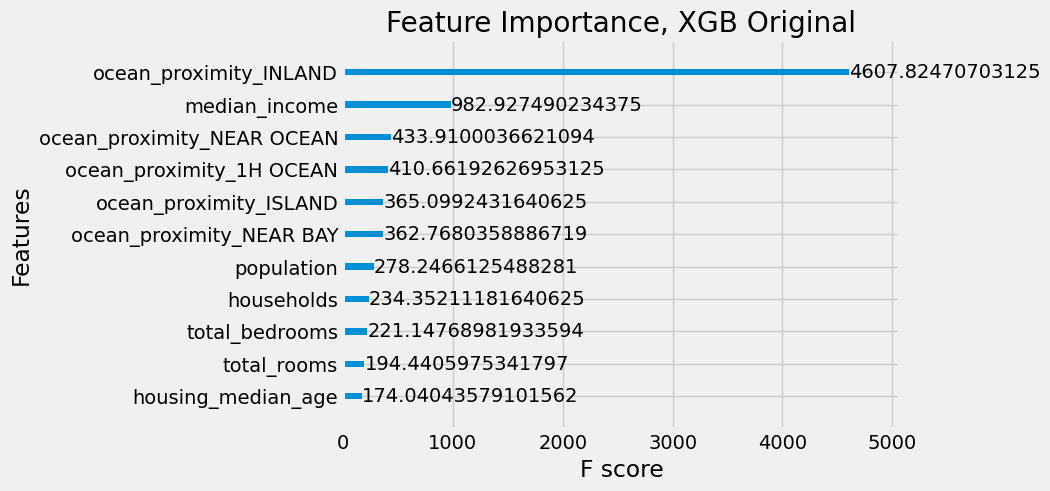

In [31]:
# ‘Gain’ is the improvement in accuracy brought by a feature to the branches it is on
# plot xgboost feature importance by gain
xgb.plot_importance(xg, importance_type='gain')
plt.title('Feature Importance, XGB Original')

# Joined Dataset and XGBoostRegressor

In [32]:
# feature names with [] or <> are rejected by XGboost, this changes a column title that throws the error
X_train_joined.rename(columns={'ocean_proximity_<1H OCEAN':'ocean_proximity_1H OCEAN'}, inplace=True)
X_test_joined.rename(columns={'ocean_proximity_<1H OCEAN':'ocean_proximity_1H OCEAN'}, inplace=True)
X_train_joined.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,bedrooms_per_rooms,rooms_per_house,pop_per_house,miles_nearest_major_city,ocean_proximity_1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
5500,0.505394,-0.428483,-0.130761,0.002228,-0.014490,-0.076678,1.066242,-0.802582,-0.017328,-0.679837,1.0,0.0,0.0,0.0,0.0
15860,1.856182,-0.146575,-0.164144,-0.334215,-0.061571,0.334265,-0.179650,-0.227740,-0.083872,-0.872019,0.0,0.0,0.0,1.0,0.0
7232,0.584852,-0.757147,-0.624345,-0.354525,-0.563767,-0.918883,1.006604,-0.793905,0.051511,-0.766615,1.0,0.0,0.0,0.0,0.0
6115,0.346478,-0.388604,-0.192757,0.319244,-0.362365,-0.635744,0.632055,-0.192429,0.180967,-0.483633,1.0,0.0,0.0,0.0,0.0
8828,0.584852,-0.571042,-0.187988,-0.486983,-0.082495,-0.678749,1.773308,-0.993857,-0.115844,-0.760900,1.0,0.0,0.0,0.0,0.0


## XGBoostRegressor Base Model and Joined Data

In [33]:
# create model
xg=xgb.XGBRegressor(random_state=5)
# fit model to joined data
xg.fit(X_train_joined, y_train_joined)
# get predictions
y_pred_xg_joined = xg.predict(X_test_joined)

# get r^2 for training and testing sets
x1 = xg.score(X_train_joined, y_train_joined)
x2 = xg.score(X_test_joined, y_test_joined)
# get variance score
evs = explained_variance_score(y_test_joined, y_pred_xg_joined)
# get rmse
rmse = np.sqrt(mean_squared_error(y_test_joined, y_pred_xg_joined))

# save metrics
metrics.append({'Model': 'XGJ_B', 'R2': x2, 'EVS': evs, 'RMSE': rmse})
# print results
print(f'RMSE of XGboost on joined testing set: {round(rmse, 3)}')
print(f'R^2 of XGboost on joined training set: {round(x1, 3)}')
print(f'R^2 of XGboost on joined testing set: {round(x2, 3)}')
print(f'Explained Variance Score of XGboost on joined testing set: {round(evs, 3)}')

RMSE of XGboost on joined training set: 54071.076
R^2 of XGboost on joined training set: 0.909
R^2 of XGboost on joined testing set: 0.788
Explained Variance Score of XGboost on joined testing set: 0.788


## Parameter Tuning XGBoostRegressor with Joined Dataset

In [34]:
# hyperparameter tuning with RandomSearchCV and XGboostregressor on joined data
# removed objective=reg:tweedie for throwing nan, inf errors
start=time.time()
# Number of trees in random forest
n_estimators=[int(i) for i in np.linspace(start = 100, stop = 700, num = 25)]
# defines the minimum sum of weights of all observations required in a child.
min_child_weight=[i for i in range(2,7)]
# Gamma specifies the minimum loss reduction required to make a split
gamma=[i/10.0 for i in range(0,7)]
# denotes the fraction of observations to be randomly samples for each tree.
subsample=[i/10.0 for i in range(4,11)]
# colsample_bytree is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
colsample=[i/10.0 for i in range(4,11)]
# The maximum depth of a tree
max_depth=[i for i in range(2,12)]
# defines the loss function to be minimize
objective=['reg:squarederror']
# 2 types of boosters - tree booster and linear booster
booster=['gbtree', 'gblinear']
# The metric to be used for validation data.
eval_metric=['rmse']
# It is analogous to learning rate, It is the step size shrinkage used in update to prevent overfitting
eta=[round(i, 2) for i in np.arange(0.01, 2.0, 0.01)]

random_grid_xg = {
    'n_estimators':n_estimators,
    'min_child_weight':min_child_weight, 
    'gamma':gamma,  
    'subsample':subsample,
    'colsample_bytree':colsample, 
    'max_depth':max_depth,
    'objective':objective,
    'booster':booster,
    'eval_metric':eval_metric,
    'eta':eta}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
xg = xgb.XGBRegressor(nthread=-1)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xg_random = RandomizedSearchCV(estimator = xg, param_distributions = random_grid_xg, n_iter = 200, cv = 3, verbose=2, random_state=5, n_jobs = -1, error_score='raise')
# Fit the random search model
xg_random.fit(X_train_joined, y_train_joined)
end=time.time()
print(f'Training Time: {end-start}')
# print best params
best_pr_joined_xg = xg_random.best_params_
print(best_pr_joined_xg)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Training Time: 699.650372505188
{'subsample': 0.7, 'objective': 'reg:squarederror', 'n_estimators': 550, 'min_child_weight': 4, 'max_depth': 11, 'gamma': 0.2, 'eval_metric': 'rmse', 'eta': 0.04, 'colsample_bytree': 0.9, 'booster': 'gbtree'}


# Train Model with best Parameters, Get metrics and predictions

In [35]:
# create model with best params from RandomSearch
xg = xgb.XGBRegressor(n_estimators=best_pr_joined_xg['n_estimators'],
                        min_child_weight=best_pr_joined_xg['min_child_weight'],
                        gamma=best_pr_joined_xg['gamma'],
                        subsample=best_pr_joined_xg['subsample'],
                        colsample_bytree=best_pr_joined_xg['colsample_bytree'],
                        max_depth=best_pr_joined_xg['max_depth'],
                        objective=best_pr_joined_xg['objective'],
                        booster=best_pr_joined_xg['booster'],
                        eval_metric=best_pr_joined_xg['eval_metric'],
                        eta=best_pr_joined_xg['eta'],random_state=5)
# fit model to joined data
xg.fit(X_train_joined, y_train_joined)
# get predictions
y_pred_xg_joined = xg.predict(X_test_joined)

# get r^2 for training and testing sets
x1 = xg.score(X_train_joined, y_train_joined)
x2 = xg.score(X_test_joined, y_test_joined)
# get variance score
evs = explained_variance_score(y_test_joined, y_pred_xg_joined)
# get rmse
rmse = np.sqrt(mean_squared_error(y_test_joined, y_pred_xg_joined))
# save metrics
metrics.append({'Model': 'XGJ_T', 'R2': x2, 'EVS': evs, 'RMSE': rmse})
# print results
print(f'RMSE of XGboost on joined testing set: {round(rmse, 3)}')
print(f'R^2 of XGboost on joined training set: {round(x1, 3)}')
print(f'R^2 of XGboost on joined testing set: {round(x2, 3)}')
print(f'Explained Variance Score of XGboost on joined testing set: {round(evs, 3)}')

RMSE of XGboost on joined training set: 51731.056
R^2 of XGboost on joined training set: 0.987
R^2 of XGboost on joined testing set: 0.806
Explained Variance Score of XGboost on joined testing set: 0.806


# Plot True Vs Predicted Values

Text(0.5, 1.0, 'True vs. Pred Value Density, XGB joined')

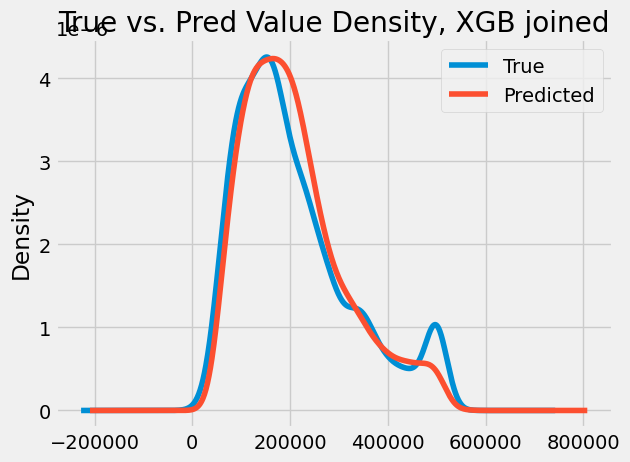

In [36]:
# plot distributions of true and predicted values
y_test_joined.plot.density(label='True')
pd.Series(y_pred_xg_joined).plot.density(label='Predicted')
plt.legend()
plt.title('True vs. Pred Value Density, XGB joined')

Text(0.5, 1.0, 'True vs. Predicted Values, XGB joined')

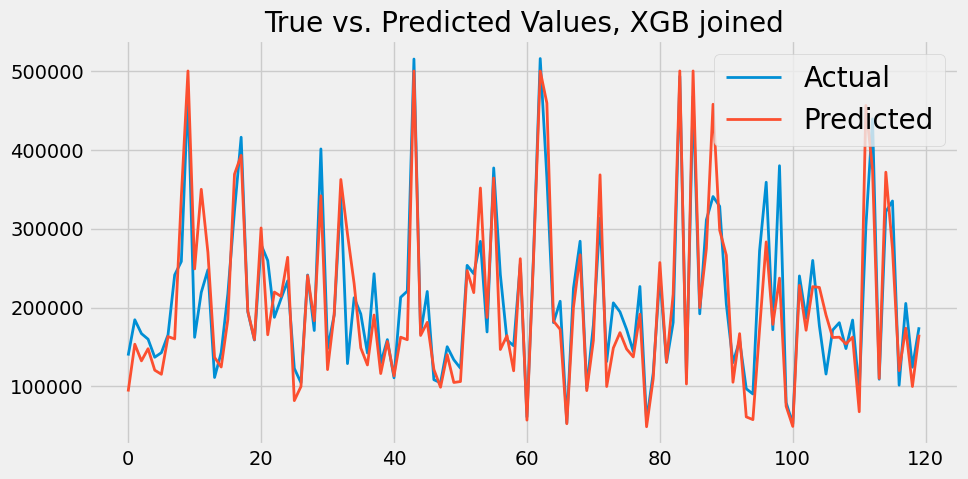

In [37]:
# show predictions
xgj = pd.DataFrame({'prediction':y_pred_xg_joined,'Actual':y_test_joined})
xgj = xgj.reset_index()
xgj = xgj.drop(['index'],axis=1)
plt.figure(figsize=(10,5))
plt.plot(xgj[:120],linewidth=2)
plt.legend(['Actual','Predicted'],prop={'size': 20})
plt.title('True vs. Predicted Values, XGB joined')

# Get Feature Importances

Text(0.5, 1.0, 'Feature Importances, XGB Joined')

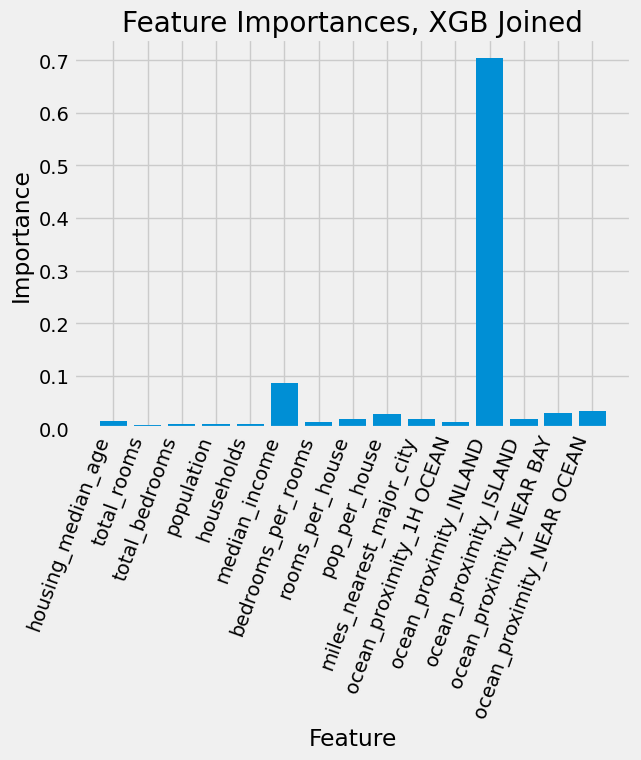

In [38]:
# plot feature importances of model
# Set the style
importances = xg.feature_importances_
feature_list = X_test_joined.columns

# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation=70, ha='right')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Feature'); plt.title('Feature Importances, XGB Joined')

Text(0.5, 1.0, 'Feature Importance, XGB Joined')

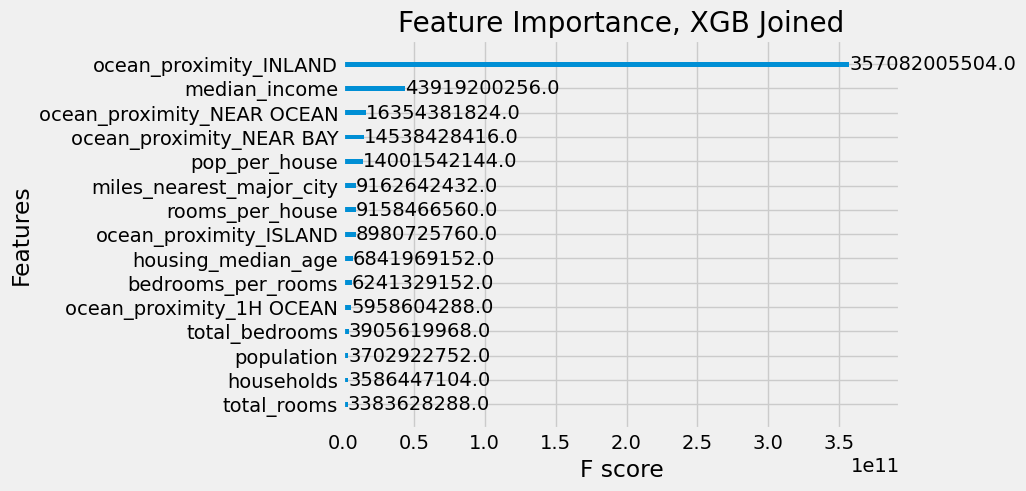

In [39]:
# ‘Gain’ is the improvement in accuracy brought by a feature to the branches it is on
# plot xgboost feature importance by gain
xgb.plot_importance(xg, importance_type='gain')
plt.title('Feature Importance, XGB Joined')

# Show all Model Metrics and Predictions

In [49]:
# show metrics table
from IPython.display import HTML
metrics_df = pd.DataFrame(metrics)
HTML(metrics_df.to_html(index=False))

Model,R2,EVS,RMSE
RFO_B,0.725021,0.725022,61574.091382
RFO_T,0.735671,0.735688,60369.881627
RFJ_B,0.786938,0.786947,54200.233781
RFJ_T,0.793455,0.793464,53364.908971
XGO_B,0.731135,0.731204,60885.648251
XGO_T,0.744496,0.745319,59353.576764
XGJ_B,0.787952,0.787985,54071.076440
XGJ_T,0.805908,0.805926,51731.056427


Text(0.5, 1.0, 'R^2 of All Models')

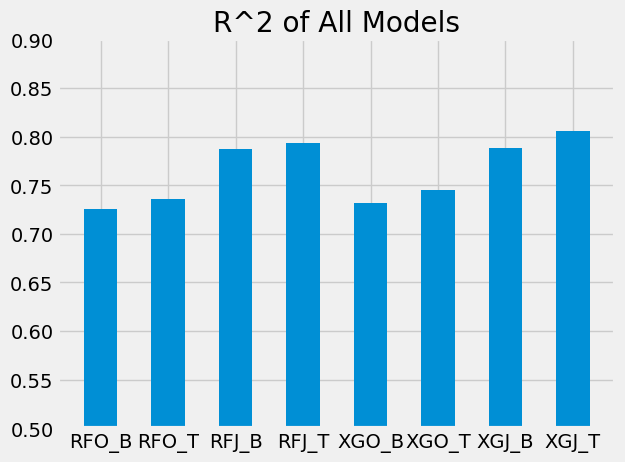

In [60]:
plt.bar(metrics_df.Model, metrics_df.R2, width=.5)
plt.ylim(0.5, 0.9)
plt.title('R^2 of All Models')

Text(0.5, 1.0, 'True vs. Predicted Values')

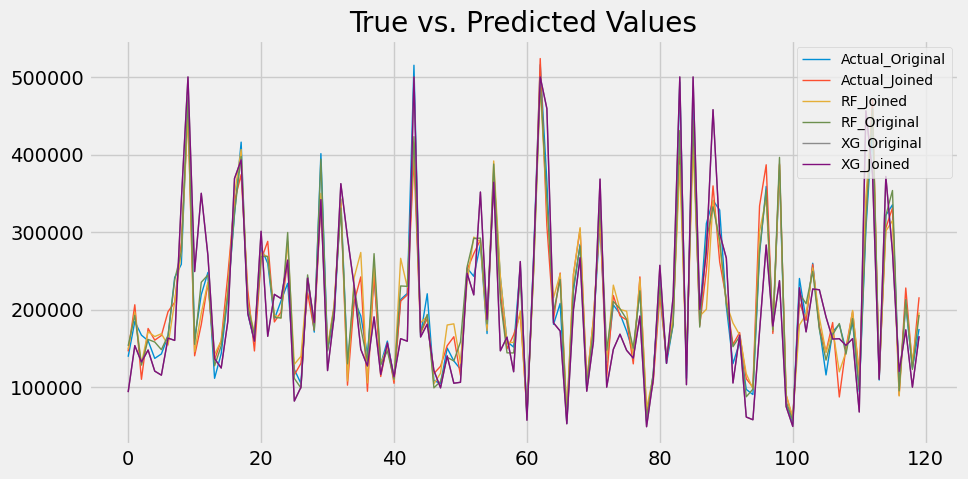

In [53]:
# show predictions
all = pd.DataFrame({'XG_Joined':y_pred_xg_joined,'XG_Original':y_pred_xg_original,
                    'RF_Original':y_pred_original,'RF_Joined':y_pred_joined,
                    'Actual_Joined':y_test_joined, 'Actual_Original':y_test_original})
all = all.reset_index()
all = all.drop(['index'],axis=1)
plt.figure(figsize=(10,5))
plt.plot(all[:120],linewidth=1)
plt.legend(['Actual_Original','Actual_Joined','RF_Joined','RF_Original','XG_Original','XG_Joined'],prop={'size': 10})
plt.title('True vs. Predicted Values')

Text(0.5, 1.0, 'True vs. Pred Value Density')

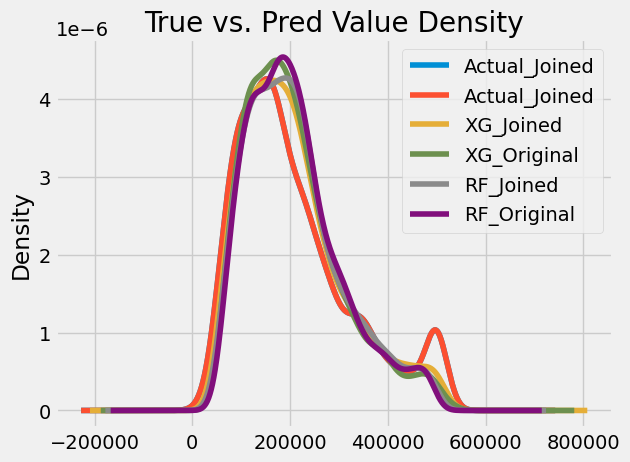

In [54]:
y_test_joined.plot.density(label='Actual_Joined')
y_test_original.plot.density(label='Actual_Joined')
pd.Series(y_pred_xg_joined).plot.density(label='XG_Joined')
pd.Series(y_pred_xg_original).plot.density(label='XG_Original')
pd.Series(y_pred_joined).plot.density(label='RF_Joined')
pd.Series(y_pred_original).plot.density(label='RF_Original')

plt.legend()
plt.title('True vs. Pred Value Density')